In [2]:
import segyio 
import obspy
from scipy import signal
from obspy.io.segy.segy import _read_segy
import numpy as np
import pywt
import cwt 

In [3]:

file = open("./TestData/cbt_processed_20160902_174053.923+0000.sgy", "r")


with segyio.open("./TestData/cbt_processed_20160902_174053.923+0000.sgy", "r", ignore_geometry=True) as f:
    print(f.bin)
    print(f.samples)
    print("n samples = ", len(f.samples))
    samples = f.samples
    
    


{JobID: 1, LineNumber: 1, ReelNumber: 1, Traces: 0, AuxTraces: 0, Interval: 20000, IntervalOriginal: 0, Samples: 3000, SamplesOriginal: 0, Format: 5, EnsembleFold: 0, SortingCode: 0, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 0, ImpulseSignalPolarity: 0, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 1, SEGYRevisionMinor: 80, TraceFlag: 0, ExtendedHeaders: 0}
[0.000e+00 2.000e+01 4.000e+01 ... 5.994e+04 5.996e+04 5.998e+04]
n samples =  3000


## Use obspy to open DAS array file
This is how the globus notebook opens the files

In [4]:
stream = _read_segy("./TestData/cbt_processed_20160912_130054.932+0000.sgy")
stats = stream.traces[0].to_obspy_trace().stats
data = np.array([stream.traces[i].data for i in range(len(stream.traces))])
print("single trace shape", stream.traces[0].data.shape)
print("full data shape", data.shape)
print(stats)


single trace shape (3000,)
full data shape (626, 3000)
         network: 
         station: 
        location: 
         channel: 
       starttime: 2016-09-12T13:00:54.000000Z
         endtime: 2016-09-12T13:01:53.980000Z
   sampling_rate: 50.0
           delta: 0.02
            npts: 3000
           calib: 1.0
            segy: AttribDict({'trace_header': LazyTraceHeaderAttribDict({'unpacked_header': b'\x00\x00\x00\x01\x00\x00\x00\x016^\x00\x06\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xf2~\xa1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\x9c\xff\x9c\x00\x00\x00\x00\x00\x00\x00\x00\x0b\x928[\x01\xadm8\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0b\xb8N \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

data given to filter [[ 1.4889988e+05  1.4896291e+05  1.4899903e+05 ...  2.7615862e+05
   2.7622306e+05  2.7627003e+05]
 [ 9.2306758e+04  9.2396766e+04  9.2495906e+04 ...  3.2982256e+05
   3.2991944e+05  3.3000606e+05]
 [ 4.6029431e+02  4.6132922e+02  4.6037296e+02 ...  1.0536475e+03
   1.0672585e+03  1.0886455e+03]
 ...
 [-1.2525501e+00 -1.2254715e+00 -1.2173767e+00 ... -1.2197266e+00
  -1.2355957e+00 -1.1972656e+00]
 [ 1.9612831e+02  1.9558020e+02  1.9723087e+02 ...  9.2744141e+02
   9.2764331e+02  9.3271387e+02]
 [-2.4939903e+02 -2.6423230e+02 -2.7548007e+02 ... -5.9714844e+01
  -5.8887939e+01 -6.0856445e+01]]
0.02
[ 4.60203801e+02  4.91855991e+02  4.44744193e+02 ... -2.79937962e-02
 -1.64410788e-02  4.57245167e-03]


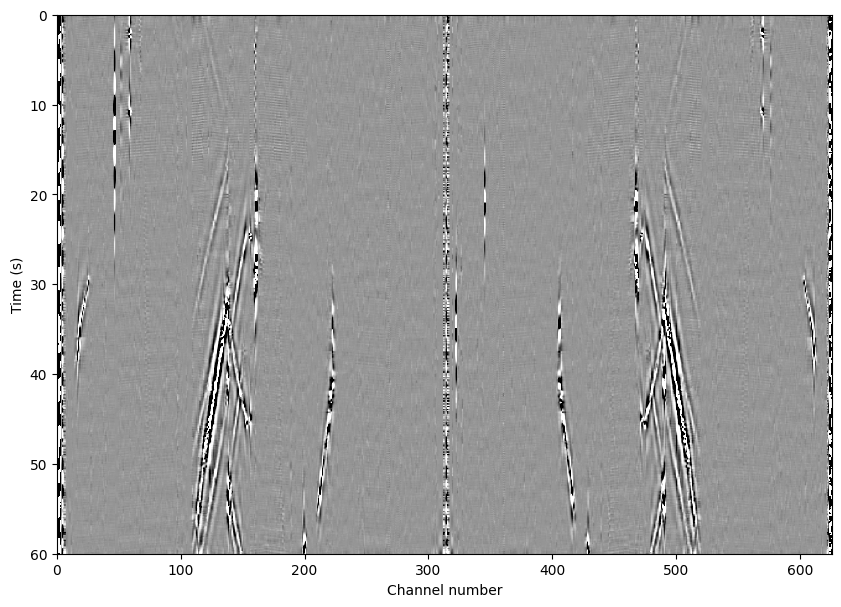

In [5]:
from matplotlib import pyplot as plt


def bpfilter(data, dt, bp_low, bp_high):
    '''
    Butterworth filter
    '''
    sos = signal.butter(6, [bp_low, bp_high], btype='bandpass', fs=1/dt, output='sos')
    print("data given to filter", data)
    return signal.sosfiltfilt(sos, data, axis=-1)

def DAS_preprocessing(data, dt, fl, fh):
    """this is important otherwise the plot doesn't look right 

    Args:
        data (_type_): _description_
        dt (_type_): _description_
        fl (_type_): _description_
        fh (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = signal.detrend(data, axis=1)
    data = data - np.median(data, axis=0)
    data = bpfilter(data, dt, fl, fh)
    print(dt)
    return data

processed_data = DAS_preprocessing(data, stats['delta'], fl=0.2, fh = 24)
obspy_filtered = stream.traces[500].to_obspy_trace().filter("bandpass",freqmin=.2,freqmax=24,corners=4,zerophase=True )
print(obspy_filtered.data)
nch, nt = processed_data.shape
dt = stats['delta']

plt.figure(figsize=[10,7])

clim = processed_data.std() / 5e3
extent = [0, nch, nt*dt, 0]
plt.imshow(processed_data.T, vmin=-clim, vmax=clim, cmap='Greys', aspect='auto', origin='upper', extent=extent)

plt.xlabel('Channel number')
plt.ylabel('Time (s)')

plt.show()

In [6]:
widths = np.geomspace(1, 1024, num=100)
minFrq = 0.2
maxFrq = 24
nf = 30
# scales from paper 
ftime = np.logspace(np.log10(minFrq), np.log10(maxFrq), nf)
time_scales = cwt.scales_from_fourier(ftime, "morlet", 8)
cwt_paper = np.abs(cwt.cwt(processed_data[600], 1.0/ 85 ,time_scales, "morlet", 8).T)
print(cwt_paper.shape)
#cwtmatr, freqs =pywt.cwt(processed_data, time_scales, "morl")



(3000, 30)


In [7]:
#print(cwtmatr.shape)

(3000,)


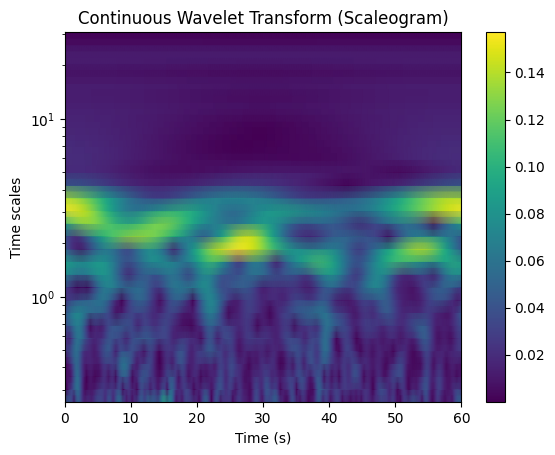

In [8]:
time = np.linspace(0, 60, 3000)
print(time.shape)
fig, axs = plt.subplots()
#print(cwtmatr.shape)
pcm = axs.pcolormesh(time, time_scales, cwt_paper.T, shading="gouraud")
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Time scales")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs)
